In [1]:
#importing utility functions
import pandas as pd
import numpy as np
import os
import sys

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# importing custom functions
# %load_ext autoreload
# %autoreload 2

module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import nb_module

In [2]:
df = pd.read_csv("./data/reddit_vm.csv")

In [3]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,Health Canada approves AstraZeneca COVID-19 va...,7,lt74vw,https://www.canadaforums.ca/2021/02/health-can...,0,1.614400e+09,NaN,2021-02-27 06:33:45
1,COVID-19 in Canada: 'Vaccination passports' a ...,2,lsh0ij,https://www.canadaforums.ca/2021/02/covid-19-i...,1,1.614316e+09,NaN,2021-02-26 07:11:07
2,Coronavirus variants could fuel Canada's third...,6,lohlle,https://www.canadaforums.ca/2021/02/coronaviru...,0,1.613887e+09,NaN,2021-02-21 07:50:08
3,Canadian government to extend COVID-19 emergen...,1,lnptv8,https://www.canadaforums.ca/2021/02/canadian-g...,0,1.613796e+09,NaN,2021-02-20 06:35:13
4,Canada: Pfizer is 'extremely committed' to mee...,6,lkslm6,https://www.canadaforums.ca/2021/02/canada-pfi...,0,1.613468e+09,NaN,2021-02-16 11:36:28


In [4]:
df.tail()

,title,score,id,url,comms_num,created,body,timestamp
1419,Comment,1,ejackaa,NaN,0,1.553486e+09,I didn't say thimerosal is mercury. I said thi...,2019-03-25 05:50:41
1420,Comment,2,ejacj98,NaN,0,1.553486e+09,"The ""myth"" you're debunking is in regards to t...",2019-03-25 05:50:20
1421,Comment,2,ejabpdx,NaN,0,1.553485e+09,You'll have to read it again because I didn't ...,2019-03-25 05:40:03
1422,Comment,0,ej9xuaf,NaN,0,1.553475e+09,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21
1423,Comment,1,ej9x2qr,NaN,0,1.553474e+09,"When they say there's no thimerasol, they mean...",2019-03-25 02:35:47


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1424 non-null   object 
 1   score      1424 non-null   int64  
 2   id         1424 non-null   object 
 3   url        444 non-null    object 
 4   comms_num  1424 non-null   int64  
 5   created    1424 non-null   float64
 6   body       1059 non-null   object 
 7   timestamp  1424 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 89.1+ KB


In [6]:
df.isna().sum()

title          0
score          0
id             0
url          980
comms_num      0
created        0
body         365
timestamp      0
dtype: int64

In [7]:
df.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [8]:
columns_to_drop = ['score', 'id', 'url', 'comms_num', 'created']
df.drop(labels = columns_to_drop, axis = 1, inplace=True)

## Data Cleaning Title

Removing any grammatical symbols from the text and converting everything to lower case 

In [9]:
df['cleaned_title'] = df['title'].apply(lambda x: nb_module.clean_data(x))
df.head()

,title,body,timestamp,cleaned_title
0,Health Canada approves AstraZeneca COVID-19 va...,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine
1,COVID-19 in Canada: 'Vaccination passports' a ...,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...
2,Coronavirus variants could fuel Canada's third...,NaN,2021-02-21 07:50:08,coronavirus variants could fuel canadas third ...
3,Canadian government to extend COVID-19 emergen...,NaN,2021-02-20 06:35:13,canadian government to extend covid emergency ...
4,Canada: Pfizer is 'extremely committed' to mee...,NaN,2021-02-16 11:36:28,canada pfizer is extremely committed to meetin...


In [10]:
len(df)

1424

In [11]:
df_cleaned_title = df[df['title'] != 'Comment']
len(df_cleaned_title)

444

In [12]:
df_cleaned_title.tail()

,title,body,timestamp,cleaned_title
440,I am a father of five unvaccinated children. A...,NaN,2014-01-13 16:55:48,i am a father of five unvaccinated children am...
441,Love Them. Protect Them. Never Inject Them.,NaN,2014-01-13 16:53:07,love them protect them never inject them
442,Vaccines Are Just Asping For Trouble,NaN,2014-01-13 16:47:31,vaccines are just asping for trouble
443,Dr. Harper explained in her presentation that ...,NaN,2014-01-13 16:44:57,dr harper explained in her presentation that t...
444,Polio arose in the US at a period where pestic...,NaN,2014-01-13 16:42:55,polio arose in the us at a period where pestic...


### Tokenize Title

In [13]:
df_cleaned_title['tokenized'] = df_cleaned_title['cleaned_title'].apply(lambda x: nb_module.tokenize(x))

### Stemming Title
-- **with Porter Stemmer**

In [15]:
df_cleaned_title['stemmed'] = df_cleaned_title['tokenized'].apply(lambda x: nb_module.stemming(x))

In [18]:
sid = SentimentIntensityAnalyzer()

In [19]:
df_cleaned_title['sentiment'] = df_cleaned_title['cleaned_title'].apply(lambda x: nb_module.find_sentiment(x))

df_cleaned_title['compound_score'] = df_cleaned_title['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])

### Vectorize Title

Converting the text into a vector where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- here, every word that appears in our corpus.

In [20]:
df_cleaned_title['vectorized'] = df_cleaned_title['tokenized'].apply(lambda x: nb_module.count_vectorize(x))

### Pickling df_cleaned_title

In [21]:
df_cleaned_title.to_pickle("./pickle/cleaned_title.pkl")

## Data Cleaning Body

In [22]:
df.head(2)

,title,body,timestamp,cleaned_title
0,Health Canada approves AstraZeneca COVID-19 va...,NaN,2021-02-27 06:33:45,health canada approves astrazeneca covid vaccine
1,COVID-19 in Canada: 'Vaccination passports' a ...,NaN,2021-02-26 07:11:07,covid in canada vaccination passports a near c...


In [23]:
len(df)

1424

In [24]:
df_cleaned_body = df.dropna(axis=0)

In [25]:
len(df_cleaned_body)

1059

In [26]:
df_cleaned_body.head()

,title,body,timestamp,cleaned_title
6,Comment,Your OP. It's not a myth. Only one vaccine con...,2019-03-25 02:34:53,comment
9,Beer after corona vaccination,"Hello hello people,\nYesterday I just got my f...",2021-02-27 05:52:47,beer after corona vaccination
10,Waiting for vaccine,The harsh reality is that particular countries...,2021-02-25 18:50:38,waiting for vaccine
13,Pertussis,I am. 50+ male. I recently had to get a new ro...,2021-02-07 04:46:03,pertussis
14,"Sobre las vacunas para el COVID19, compilación...",A propósito de los comentarios que he leído y ...,2021-02-02 05:56:13,sobre las vacunas para el compilación de text...


In [27]:
df_cleaned_body.tail()

,title,body,timestamp,cleaned_title
1419,Comment,I didn't say thimerosal is mercury. I said thi...,2019-03-25 05:50:41,comment
1420,Comment,"The ""myth"" you're debunking is in regards to t...",2019-03-25 05:50:20,comment
1421,Comment,You'll have to read it again because I didn't ...,2019-03-25 05:40:03,comment
1422,Comment,"What do you mean by ""your OP"". I am fairly new...",2019-03-25 02:45:21,comment
1423,Comment,"When they say there's no thimerasol, they mean...",2019-03-25 02:35:47,comment


In [28]:
df_cleaned_body['cleaned_body'] = df_cleaned_body['body'].apply(lambda x: nb_module.clean_data(x))

In [29]:
df_cleaned_body['tokenized'] = df_cleaned_body['cleaned_body'].apply(lambda x: nb_module.tokenize(x))

In [30]:
df_cleaned_body['stemmed'] = df_cleaned_body['tokenized'].apply(lambda x: nb_module.stemming(x))

In [31]:
df_cleaned_body['vectorized'] = df_cleaned_body['tokenized'].apply(lambda x: nb_module.count_vectorize(x))

In [33]:
df_cleaned_body['sentiment'] = df_cleaned_body['cleaned_title'].apply(lambda x: nb_module.find_sentiment(x))

df_cleaned_body['compound_score'] = df_cleaned_body['cleaned_title'].apply(lambda x: sid.polarity_scores(x)['compound'])

### Pickling body dataset

In [34]:
df_cleaned_body.to_pickle("./pickle/cleaned_body.pkl")

## Visuals


Proportion Sentiment in title
negative    38.06
neutral     31.76
positive    30.18
Name: sentiment, dtype: float64


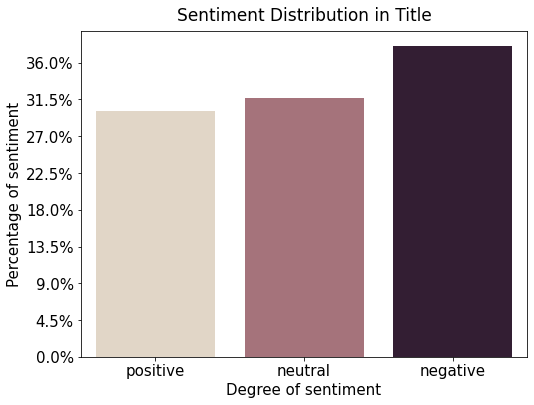

In [42]:
import matplotlib.ticker as ticker

print("Proportion Sentiment in title")
print(round(df_cleaned_title['sentiment'].value_counts(normalize=True)*100, 2))

# Set up figure, axes and draw the plot
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x="sentiment", palette="ch:.25", data=df_cleaned_title)

#Set axes ticks
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = len(df_cleaned_title)))
ax.tick_params(axis='both', labelsize= 15)

#set axes label and title
ax.set_ylabel('Percentage of sentiment', size=15)
ax.set_xlabel('Degree of sentiment', size = 15)
ax.set_title("Sentiment Distribution in Title", size=17, pad= 10)
fig.savefig('./images/sentiment_proportion_title.png', bbox_inches = "tight");



Proportion Sentiment in Body
neutral     96.41
positive     2.08
negative     1.51
Name: sentiment, dtype: float64


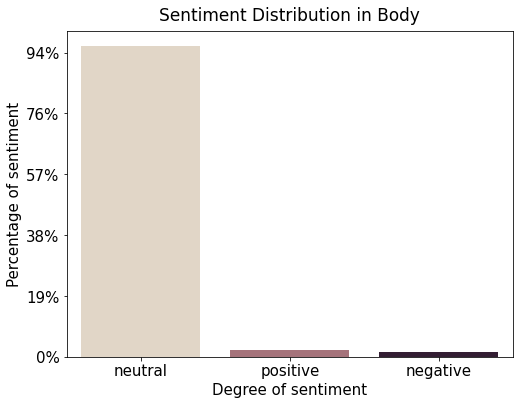

In [43]:
print("Proportion Sentiment in Body")
print(round(df_cleaned_body['sentiment'].value_counts(normalize=True)*100, 2))

# Set up figure, axes and draw the plot
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(x="sentiment", palette="ch:.25", data=df_cleaned_body)

#Set axes ticks
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = len(df_cleaned_body)))
ax.tick_params(axis='both', labelsize= 15)

#set axes label and title
ax.set_ylabel('Percentage of sentiment', size=15)
ax.set_xlabel('Degree of sentiment', size = 15)
ax.set_title("Sentiment Distribution in Body", size=17, pad= 10)
fig.savefig('./images/sentiment_proportion_body.png', bbox_inches = "tight");



In [40]:
from datetime import datetime

In [41]:
time_series_df = df_cleaned.copy()
time_series_df['timestamp'] = pd.to_datetime(time_series_df['timestamp'])
time_series_df['date'] = [d.date() for d in time_series_df['timestamp']]
time_series_df.set_index(['date', 'sentiment'], inplace=True)

NameError: name 'df_cleaned' is not defined

In [ ]:
time_series_df.head()

In [ ]:
sentiment_volume = pd.DataFrame(time_series_df.groupby(['date', 'sentiment']).size(), columns = ['sentiment_count'])

In [ ]:
sentiment_volume.head(2)

In [ ]:
# sentiment_volume['date'] = pd.to_datetime(sentiment_volume['date'], format = '%Y-%m-%d')

In [ ]:
sentiment_volume.set_index('date', inplace=True)

In [ ]:
sentiment_volume.head(2)

In [ ]:
sentiment_vol_1 = sentiment_volume['sentiment_count'].unstack().reset_index()

In [ ]:
sentiment_vol_1.set_index('date', inplace=True)

In [ ]:
sentiment_vol_1.head()

In [ ]:
sentiment_vol_1.fillna(0, inplace= True )

In [ ]:
sentiment_vol_monthly = sentiment_vol_1.resample('MS').sum()

In [ ]:
sentiment_vol_monthly.plot(figsize = (10, 7))

### Vectorization

Converting the text into a vector where each element in the vector represents a different word.
The vector is the length of the entire vocabulary -- here, every word that appears in our corpus.

### TF-IDF Vectorization
TF-IDF is a more advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in. This allows us to summarize the contents of a document using a few KEY WORDS.

If the word is used often in many other documents, it is not unique and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents.

Conversely, if a word is used many times in a document, but rarely in all the other documents we are looking into, then it is likely a good indicator for telling us that this word is important to the document in question

In [ ]:
# Function to calculate the TF